In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import sys
import itertools
import os
from itertools import groupby
from random import sample

warnings.simplefilter('ignore', pd.errors.DtypeWarning)
np.seterr(divide='ignore')
warnings.simplefilter("ignore")

sys.path.append('/sise/home/shakarch/muscle-formation-regeneration')
sys.path.append(os.path.abspath('..'))

import TimeSeriesAnalysis.analysis.calc_single_cell_properties as calcultator 
import TimeSeriesAnalysis.analysis.utils as utils
import TimeSeriesAnalysis.configuration.consts as consts

## data loading - differentiation scores dataframes

In [2]:
scores_df_s3 = utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S3.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S3.pkl")

scores_df_s2 = utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S2.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S2.pkl")

scores_df_s5 = utils.get_scores_df(scores_motility_path=consts.motility_model_path % (2,3) + fr"df_score_vid_num_S5.pkl",
                              scores_intensity_path=consts.intensity_model_path % (2,3) + fr"df_score_vid_num_S5.pkl")

scores_df_s1 = utils.get_scores_df(scores_motility_path=consts.motility_model_path % (2,3) + fr"df_score_vid_num_S1.pkl",
                              scores_intensity_path=consts.intensity_model_path % (2,3) + fr"df_score_vid_num_S1.pkl")

In [3]:
scores_df_s3 = calcultator.get_properties(scores_df_s3, vid_name="S3", actin_vid_path=consts.s_runs["3"]['actin_path'])
scores_df_s2 = calcultator.get_properties(scores_df_s2, vid_name="S2", actin_vid_path=consts.s_runs["2"]['actin_path'])
scores_df_s5 = calcultator.get_properties(scores_df_s5, vid_name="S5", actin_vid_path=consts.s_runs["5"]['actin_path'])
scores_df_s1 = calcultator.get_properties(scores_df_s1, vid_name="S1", actin_vid_path=consts.s_runs["1"]['actin_path'])

## Analyse single cells speed & actin intensity

### Speed

S3 video (ERK)

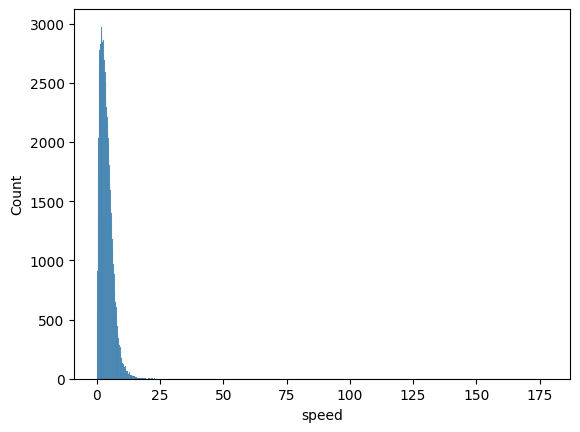

In [4]:
sns.histplot(data=scores_df_s3, x="speed")
plt.show()

In [105]:
# remove outlaiers
def remove_speed_outlaiers(scores_df, speed_threshold):
    
    # cells with missing timepont in the track (causes a bias in speed)
    miss_step_tracks = set()
    for track_id, track in scores_df.groupby(['Spot track ID']):
        if track["Spot frame"].diff().max()>1:
            miss_step_tracks.add(track_id)

    # cells with speed higher then 20
    speed_outliars = set(scores_df[scores_df["speed"] >= speed_threshold]['Spot track ID'].unique())

    # remove bad tracks for calculation
    track_ids = set(scores_df['Spot track ID'].unique()) - speed_outliars - miss_step_tracks

    fraction = round((len(speed_outliars) +len(miss_step_tracks))/scores_df['Spot track ID'].nunique(),3)
    print(f"we removed {fraction * 100}% of the tracked cells")
    
    return track_ids

def plot_single_cell_property(scores_df, ids_to_plot, property_name, rolling_w=12, plot_mean=True, color="gray"):
    
    for track_id, track in scores_df[scores_df['Spot track ID'].isin(ids_to_plot)].groupby(['Spot track ID']):
        plt.plot(track["time"].rolling(rolling_w).mean(), track[property_name].rolling(rolling_w).mean(), linewidth=0.2, color=color)
    
    if plot_mean:
        plt.plot(scores_df.dropna(subset=[property_name]).groupby("time")[property_name].mean().rolling(rolling_w).mean())
    plt.grid(False)
    plt.xlabel("time")
    plt.ylabel(property_name)
    plt.show()

    print(f"Number of cells in this analysis: ", len(ids_to_plot))
    
    
def plot_property_over_time(df, label, color, feature, time=(0,25)):
    df = df[(df["time"]>= time[0]) & (df["time"]< time[1])]
    df = df.sort_values("time")
    mean = round(df.dropna(subset=[feature]).groupby("time")[feature].mean(), 2).rolling(1).mean()
    std = round(df.dropna(subset=[feature]).groupby("time")[feature].std(), 2).rolling(1).mean()
    plt.grid(False)
    plt.plot(mean, color=color, label=label)
    plt.fill_between(df["time"].unique()[:len(mean)], mean - std, mean + std, alpha=0.4, color=color, label=label)

    plt.axvspan(6, 13, alpha=0.3, color='lightgray')
    plt.axvline(6, color='gray', linestyle='dashed')
    plt.axvline(13, color='gray', linestyle='dashed')

    plt.ylabel(feature)
    plt.xlabel("time")
    plt.title(f'{feature} over time')
    
    plt.legend()
    plt.show()

speed ranges between 0 and 15 um/5 min, with several outliars due to technical problems in tracking 
(missing spot within the track can cause a biased speed, for example)
We will now remove them to clean our data.

we removed 22.1% of the tracked cells


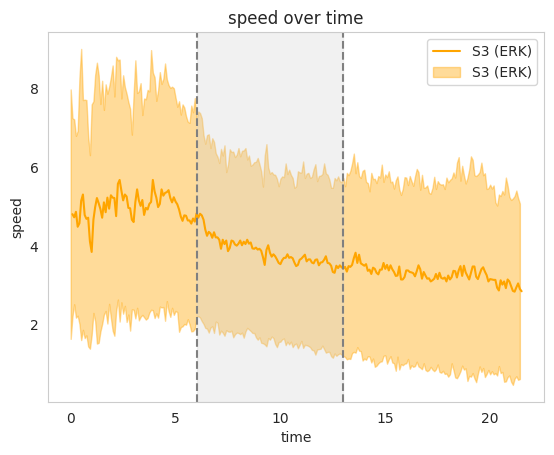

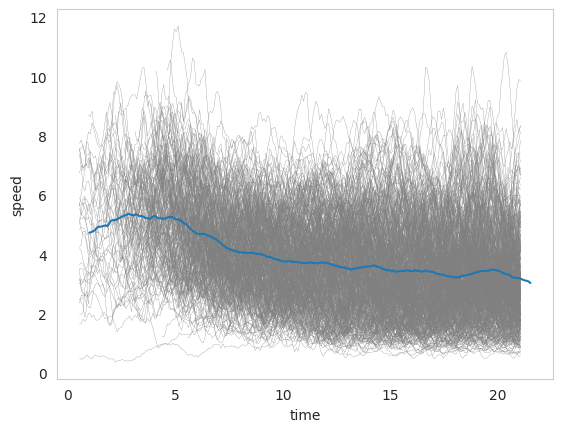

Number of cells in this analysis:  530


In [91]:
ids_to_plot = remove_speed_outlaiers(scores_df_s3, speed_threshold=20)   
plot_property_over_time(scores_df_s3[scores_df_s3["Spot track ID"].isin(ids_to_plot)], "S3 (ERK)","orange", "speed")
plot_single_cell_property(scores_df_s3, ids_to_plot, "speed", rolling_w=12)

lets sample some single cells to plot

4886


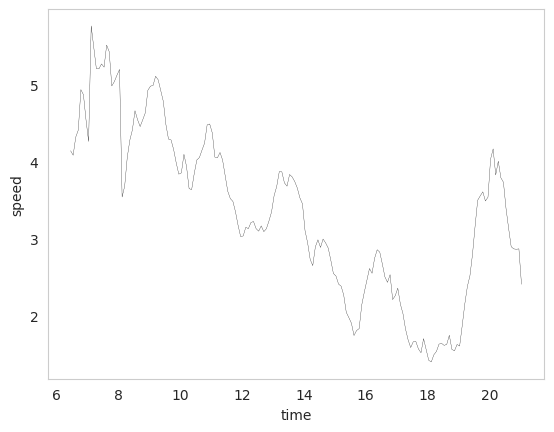

Number of cells in this analysis:  1
25558


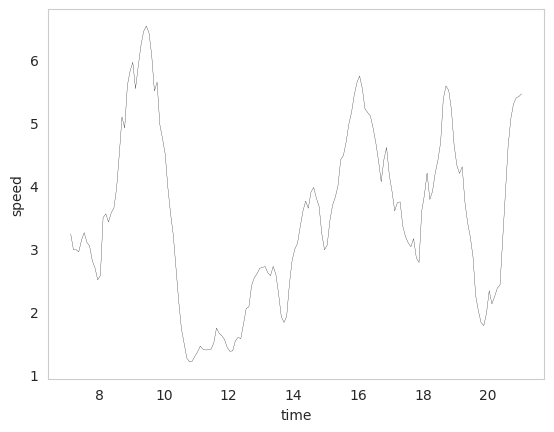

Number of cells in this analysis:  1
1583


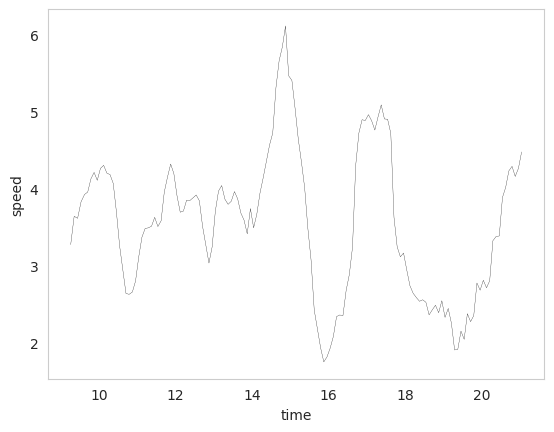

Number of cells in this analysis:  1
961


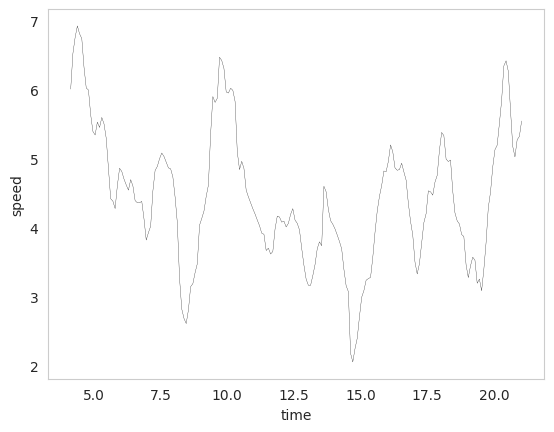

Number of cells in this analysis:  1


In [113]:
for track_id in sample(ids_to_plot, 4):
    print(track_id)
    plot_single_cell_property(scores_df_s3, [track_id], "speed", rolling_w=12, plot_mean=False, color="black")

S5 video (ERK)

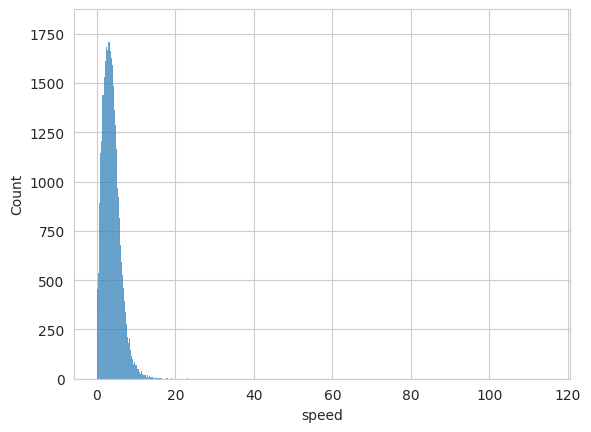

In [44]:
sns.histplot(data=scores_df_s5, x="speed")
plt.show()

we removed 27.1% of the tracked cells


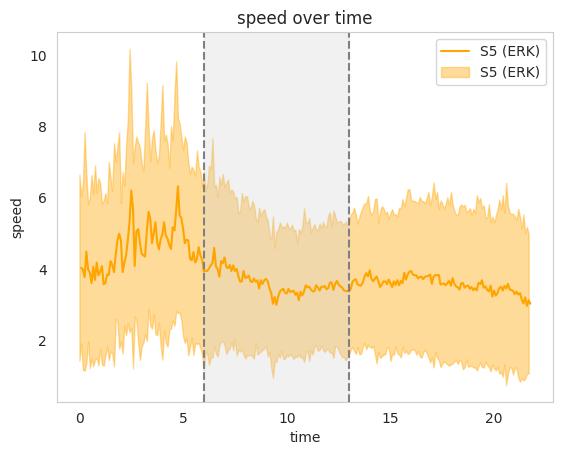

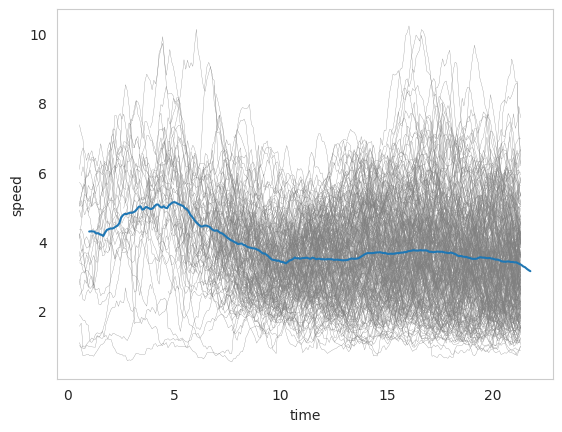

Number of cells in this analysis:  307


In [49]:
ids_to_plot = remove_speed_outlaiers(scores_df_s5, speed_threshold=30)   
plot_property_over_time(scores_df_s5[scores_df_s5["Spot track ID"].isin(ids_to_plot)], "S5 (ERK)","orange", "speed")
plot_single_cell_property(scores_df_s5, ids_to_plot, "speed", rolling_w=12)

### Actin intensity (mean)

In [9]:
# remove outlaiers
 
def remove_mean_actin_outlaiers(scores_df, low_threshold, high_threshold):
    """
    """
    
    track_ids_mean = set(scores_df[(scores_df["mean"] > low_threshold) & (scores_df["mean"] < high_threshold)]['Spot track ID'].unique())
    
    removed_tracks_num = scores_df['Spot track ID'].nunique() - len(track_ids_mean)
    fraction = round(removed_tracks_num/scores_df['Spot track ID'].nunique(),3)

    print(f"we removed {fraction * 100}% of the tracked cells")
    
    return track_ids_mean

S3 video (ERK)

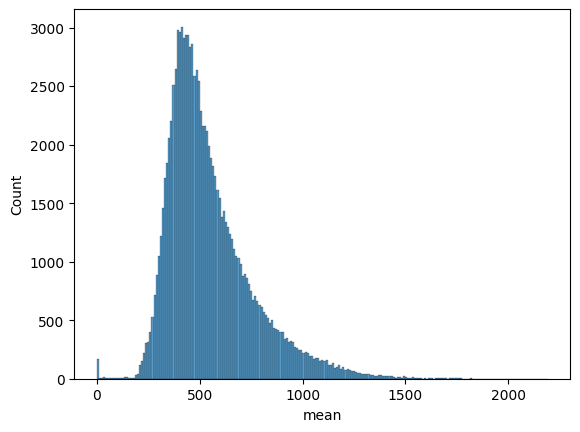

In [10]:
sns.histplot(data=scores_df_s3, x="mean")
plt.show()

mean actin intensity ranges between <0 and ~2000, with several outliars.
We will now remove them to clean our data.

we removed 12.1% of the tracked cells


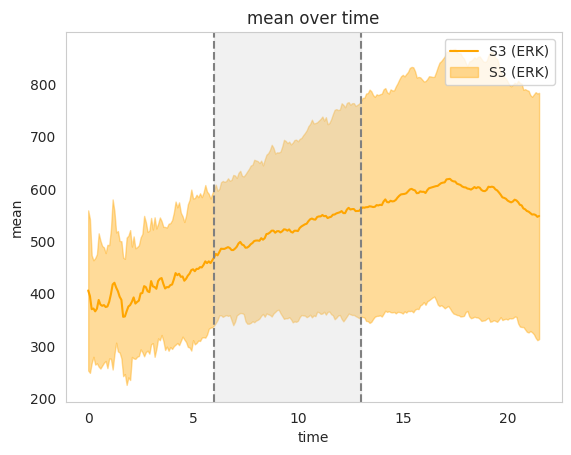

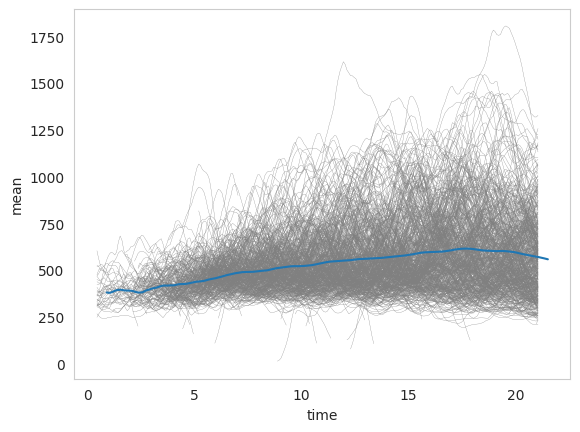

Number of cells in this analysis:  593


In [96]:
ids_to_plot = remove_mean_actin_outlaiers(scores_df_s3, 0, 2000)
plot_property_over_time(scores_df_s3[scores_df_s3["Spot track ID"].isin(ids_to_plot)], "S3 (ERK)","orange", "mean")
plot_single_cell_property(scores_df_s3, ids_to_plot, "mean", rolling_w=12)

S5 video (ERK)

28326


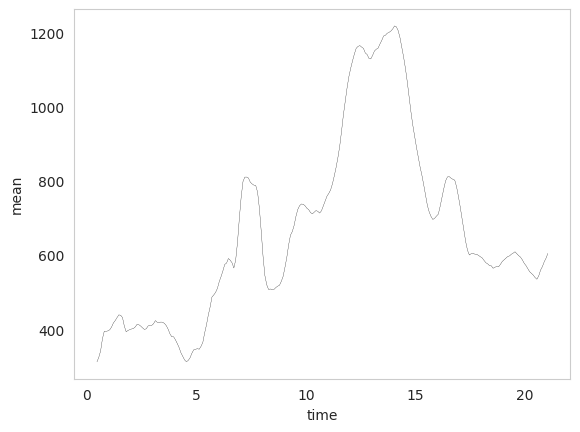

Number of cells in this analysis:  1
26635


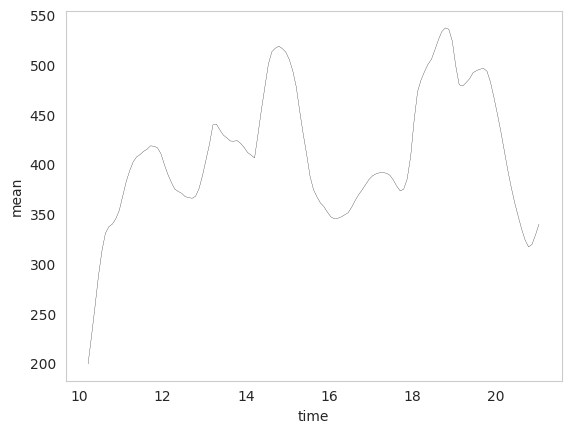

Number of cells in this analysis:  1
10981


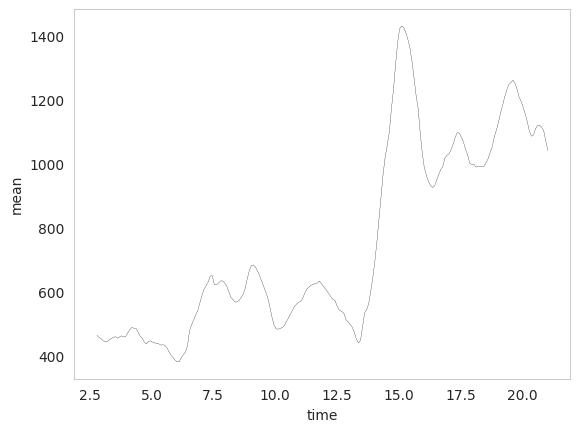

Number of cells in this analysis:  1


In [114]:
for track_id in sample(ids_to_plot, 3):
    print(track_id)
    plot_single_cell_property(scores_df_s3, [track_id], "mean", rolling_w=12, plot_mean=False, color="black")

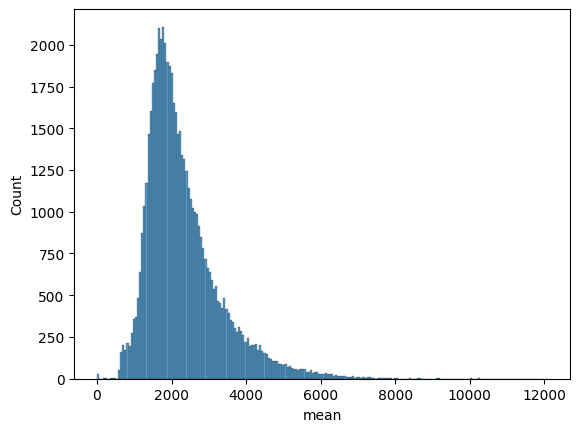

In [12]:
sns.histplot(data=scores_df_s5, x="mean")
plt.show()

we removed 1.4000000000000001% of the tracked cells


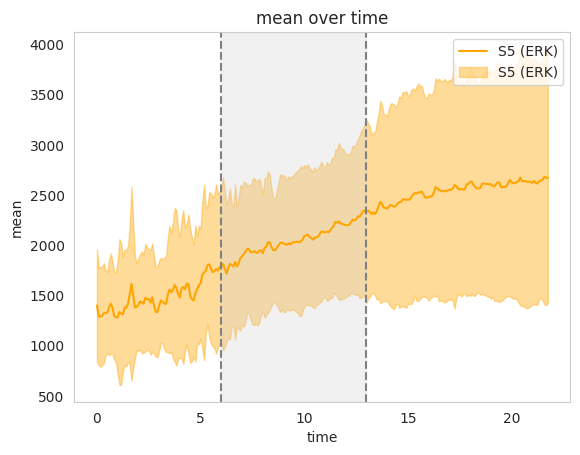

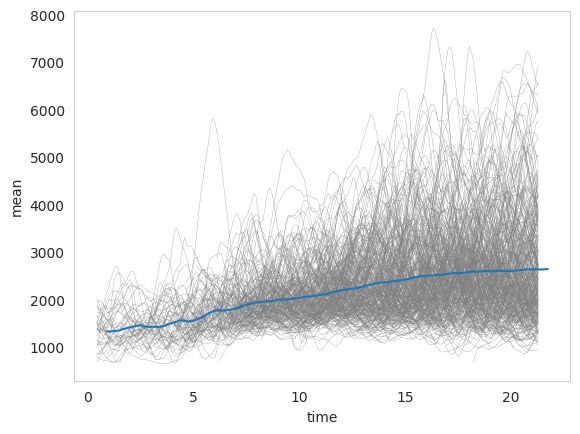

Number of cells in this analysis:  414


In [51]:
ids_to_plot = remove_mean_actin_outlaiers(scores_df_s5, 0, 10000)
plot_property_over_time(scores_df_s5[scores_df_s5["Spot track ID"].isin(ids_to_plot)], "S5 (ERK)","orange", "mean")
plot_single_cell_property(scores_df_s5, ids_to_plot, "mean", rolling_w=12)